In [1]:
! pip install pandas

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [4]:
from google.colab import drive
pd.set_option('display.float_format', lambda x: '%.3f' % x)
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
data = pd.read_stata('/content/drive/MyDrive/econometrics/Panel101.dta')

In [6]:
data.head(1)

,country,year,y,y_bin,x1,x2,x3,opinion,op
0,A,1990,1342787840.000,1.000,0.278,-1.108,0.283,Str agree,1.000


In [20]:
data.describe()

,year,y,y_bin,x1,x2,x3,op
count,70.000,70.000,70.000,70.000,70.000,70.000,70.000
mean,1994.500,1845072181.057,0.800,0.648,0.134,0.762,0.500
std,2.893,3015166973.188,0.403,0.468,1.371,1.446,0.504
min,1990.000,-7863482880.000,0.000,-0.568,-1.622,-1.165,0.000
25%,1992.000,246571560.000,1.000,0.329,-1.216,-0.079,0.000
50%,1994.500,1897897536.000,1.000,0.641,-0.462,0.514,0.500
75%,1997.000,3372262464.000,1.000,1.096,1.608,1.155,1.000
max,1999.000,8941232128.000,1.000,1.446,2.530,7.169,1.000


In [22]:
# 1. Identify treatment and control groups based on opinion
treatment_prop = data.groupby('country')['op'].mean()
treatment_status = treatment_prop > 0.5  # If more than 50% positive opinions, classify as treatment
data['treatment'] = data['country'].map(treatment_status)

# Create treatment period indicator (treatment starts from 1995)
data['post'] = data['year'] >= 1995
data['did'] = data['treatment'] * data['post']

print("\nTreatment Status by Country:")
print(treatment_status)


Treatment Status by Country:
country
A    False
B    False
C     True
D    False
E    False
F     True
G    False
Name: op, dtype: bool


<ipython-input-22-3129046a96ea>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatment_prop = data.groupby('country')['op'].mean()


In [23]:
# 2. Check parallel trends assumption (pre-treatment period)
pre_treatment = data[data['year'] < 1995].copy()
pre_treatment['year_trend'] = pre_treatment['year'] - 1990
pre_treatment['treat_year'] = pre_treatment['treatment'].astype(float) * pre_treatment['year_trend']

# Convert to numpy arrays for the regression
y = np.array(pre_treatment['y'], dtype=float)
X = np.array(pre_treatment[['treatment', 'year_trend', 'treat_year']], dtype=float)
X = sm.add_constant(X)

parallel_model = sm.OLS(y, X)
parallel_results = parallel_model.fit()

print("\nParallel Trends Test:")
print(parallel_results.summary().tables[1])


Parallel Trends Test:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.464e+08   8.95e+08     -0.164      0.871   -1.97e+09    1.68e+09
x1         -7.187e+08   1.67e+09     -0.429      0.671   -4.13e+09     2.7e+09
x2          7.103e+08   3.65e+08      1.944      0.061    -3.5e+07    1.46e+09
x3          9.785e+08   6.84e+08      1.431      0.162   -4.16e+08    2.37e+09


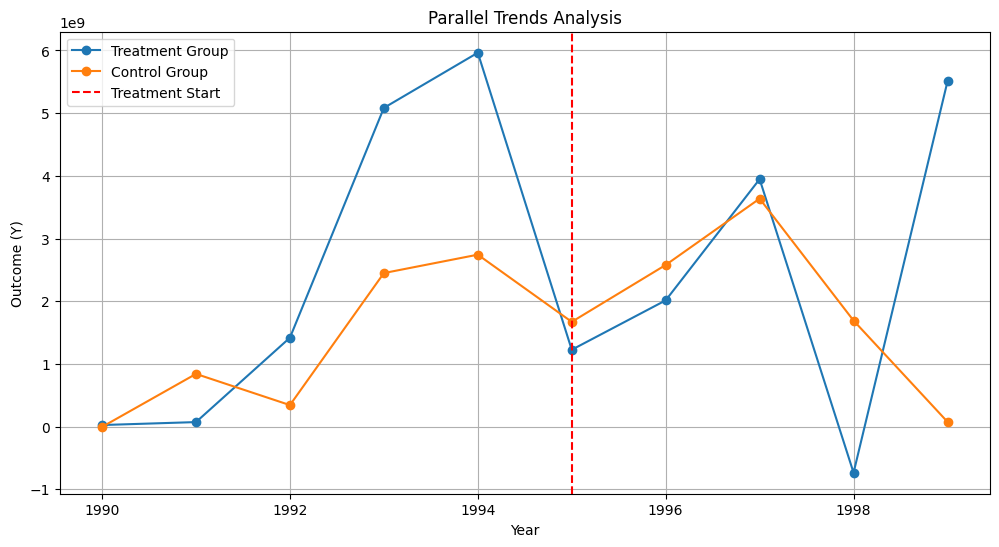

In [24]:
# 3. Plot parallel trends
trends = data.groupby(['year', 'treatment'])['y'].mean().reset_index()
trends_wide = trends.pivot(index='year', columns='treatment', values='y')

plt.figure(figsize=(12, 6))
plt.plot(trends_wide.index, trends_wide[True], label='Treatment Group', marker='o')
plt.plot(trends_wide.index, trends_wide[False], label='Control Group', marker='o')
plt.axvline(x=1995, color='r', linestyle='--', label='Treatment Start')
plt.title('Parallel Trends Analysis')
plt.xlabel('Year')
plt.ylabel('Outcome (Y)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# 4. Run DiD regression
y = np.array(data['y'], dtype=float)
X = np.array(data[['treatment', 'post', 'did', 'x1', 'x2', 'x3']], dtype=float)
X = sm.add_constant(X)

did_model = sm.OLS(y, X)
did_results = did_model.fit()

print("\nDiD Regression Results:")
print(did_results.summary().tables[1])



DiD Regression Results:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.373e+08   9.09e+08      0.811      0.421   -1.08e+09    2.55e+09
x1          1.834e+09   1.38e+09      1.331      0.188   -9.19e+08    4.59e+09
x2          5.023e+08   8.95e+08      0.561      0.577   -1.29e+09    2.29e+09
x3         -8.796e+08   1.64e+09     -0.535      0.594   -4.16e+09     2.4e+09
x4          2.889e+08    9.6e+08      0.301      0.765   -1.63e+09    2.21e+09
x5          3.689e+08   4.26e+08      0.866      0.390   -4.83e+08    1.22e+09
x6          2.909e+08   3.49e+08      0.834      0.407   -4.06e+08    9.88e+08


In [26]:
# 5. Calculate average treatment effect
treated_post = data[(data['treatment'] == True) & (data['post'] == True)]['y'].mean()
treated_pre = data[(data['treatment'] == True) & (data['post'] == False)]['y'].mean()
control_post = data[(data['treatment'] == False) & (data['post'] == True)]['y'].mean()
control_pre = data[(data['treatment'] == False) & (data['post'] == False)]['y'].mean()

ate = (treated_post - treated_pre) - (control_post - control_pre)
print("\nAverage Treatment Effect:", f"{ate:,.2f}")


Average Treatment Effect: -777,282,540.08


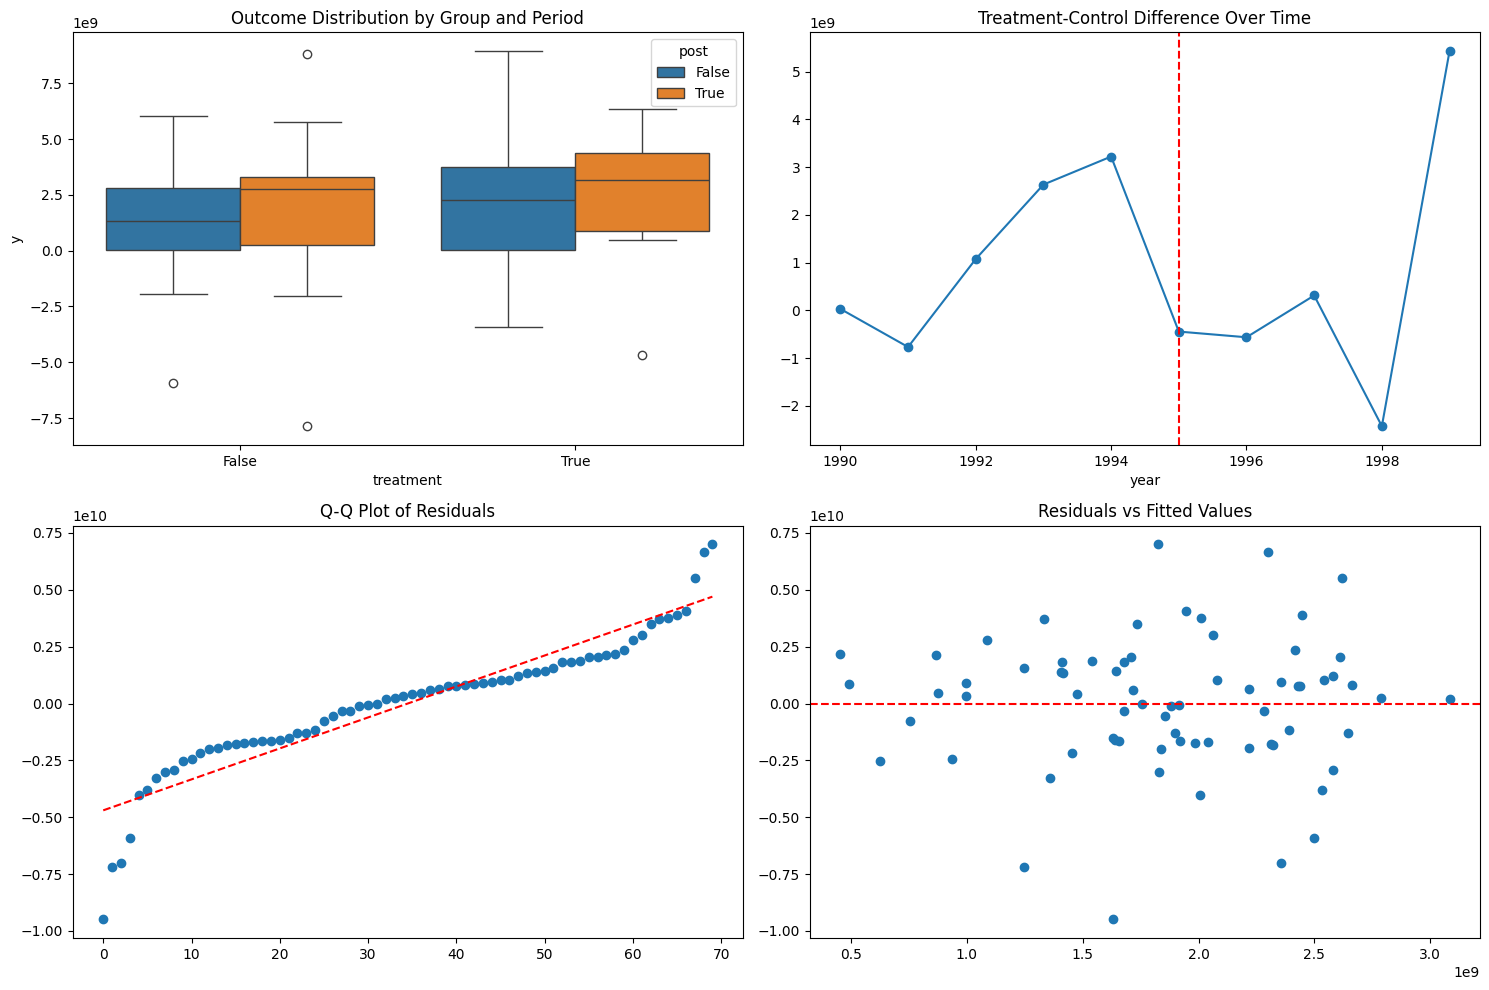

In [27]:
# 6. Diagnostic plots (fixed version)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Outcome distributions
sns.boxplot(x='treatment', y='y', hue='post', data=data, ax=axes[0,0])
axes[0,0].set_title('Outcome Distribution by Group and Period')

# Treatment effects over time
yearly_effects = data.groupby(['year', 'treatment'])['y'].mean().unstack()
yearly_effects['difference'] = yearly_effects[True] - yearly_effects[False]
yearly_effects['difference'].plot(ax=axes[0,1], marker='o')
axes[0,1].axvline(x=1995, color='r', linestyle='--')
axes[0,1].set_title('Treatment-Control Difference Over Time')

# Q-Q plot (fixed version)
residuals = did_results.resid  # Remove .values since it's already numpy array
qq_x = np.arange(len(residuals))
qq_y = np.sort(residuals)
axes[1,0].plot(qq_x, qq_y, 'o')
z = np.polyfit(qq_x, qq_y, 1)
p = np.poly1d(z)
axes[1,0].plot(qq_x, p(qq_x), "r--")
axes[1,0].set_title('Q-Q Plot of Residuals')

# Residuals vs fitted
axes[1,1].scatter(did_results.fittedvalues, residuals)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_title('Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

In [28]:
# 7. Print key statistics
print("\nKey Statistics by Group and Period:")
stats_df = data.groupby(['treatment', 'post'])['y'].agg(['mean', 'std', 'count']).round(2)
print(stats_df)


Key Statistics by Group and Period:
                          mean            std  count
treatment post                                      
False     False 1274177566.160 2518993267.870     25
          True  1930461856.640 3137727567.600     25
True      False 2512452480.000 3900475138.080     10
          True  2391454230.400 3091676465.050     10


In [29]:
# 8. Print detailed regression interpretation
coefs = dict(zip(['const', 'treatment', 'post', 'did', 'x1', 'x2', 'x3'], did_results.params))
pvals = dict(zip(['const', 'treatment', 'post', 'did', 'x1', 'x2', 'x3'], did_results.pvalues))

print("\nDetailed DiD Results:")
print(f"Treatment Effect (DiD coefficient): {coefs['did']:,.2f}")
print(f"P-value: {pvals['did']:.4f}")
print(f"Significant at 5% level: {'Yes' if pvals['did'] < 0.05 else 'No'}")


Detailed DiD Results:
Treatment Effect (DiD coefficient): -879,580,059.49
P-value: 0.5943
Significant at 5% level: No
